In [79]:
import pandas as pd
%matplotlib inline
%pylab inline

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
pylab.rcParams['figure.figsize'] = (20, 10) 
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from sklearn.model_selection import train_test_split

In [95]:
df = pd.read_csv('./AQdata_clean.csv')
dailyMean = pd.read_csv('./AQdata_dailyMean.csv')
dailyMax = pd.read_csv('./AQdata_dailyMax.csv')

In [96]:
df = df.rename(columns={'ewma': 'AQI'})
chem = 'PT08.S4(NO2)' # target chemical we want to analyze 
trainset_col = ['idx', 'Day', 'Hour', 'Weekday', 'Week', 'Month']

## Prepare the data for Machine Learning algorithms¶


In [97]:
df.columns 
# time :'Date', 'Day', 'Hour', 'Weekday', 'Week'
# 1 level chemicals: 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)'
# 2 level chemicals: 'CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)'
# environmental condition: 'T', 'RH','AH'
# traget: 'AQI'
df = df.set_index('DateTime')

In [227]:
# spliting trainset and testset manually 
week = 24 * 7
trainset = df[:-2*week] #not training set because year set contain train and dev set
devset = df[-2*week : -1*week]
testset = df[-1*week:] # will use it in the end

for data in [trainset, devset, testset]:
    print(data.shape, data.iloc[0].Date, data.iloc[-1].Date )

(9021, 20) 2004-03-10 2005-03-21
(168, 20) 2005-03-21 2005-03-28
(168, 20) 2005-03-28 2005-04-04


In [228]:
# from sklearn.model_selection import train_test_split
def separate_df(df, cols):
    print('Midding in columns:',df.isna().sum(axis=0).values, 'Filled with ffill')
    X = df[cols].fillna(method = 'ffill')
    y = df['AQI'].fillna(method = 'ffill')
    return X,y

In [229]:
X_train,y_train = separate_df(trainset, trainset_col)
X_dev,y_dev = separate_df(devset, trainset_col)

Midding in columns: [   0    0    0    0    0    0    0  366  366  366  366  366 1678  366 1639
 1642  366  366  366    0] Filled with ffill
Midding in columns: [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0] Filled with ffill


In [149]:
print("X_train's shape is: ", X_train.shape) #for train
print("y_train's shape is: ", y_train.shape) #for train
print("X_def's shape is: ", X_dev.shape) # for predict
print("y_def's shape is: ", y_dev.shape) # for score

X_train's shape is:  (9021, 6)
y_train's shape is:  (9021,)
X_def's shape is:  (168, 6)
y_def's shape is:  (168,)


In [150]:
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.svm import SVR 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import BayesianRidge
# from sklearn.neural_network import MLPRegressor

def run_models(X_train, X_def, y_train, y_def):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)
    print('Model_1: LinearRegression, score: ', lin_reg.score(X_def, y_def))
    
    knn = neighbors.KNeighborsRegressor(7)
    knn.fit(X_train, y_train.values.ravel())
    # 使用 fit 來建置模型，其參數接收 training data matrix, defing data array，所以進行 y_train.values.ravel() 轉換
    print('Model_2: KNeighborsRegressor, score:', knn.score(X_def, y_def))
    
    clf = SVR(C = 0.0001, epsilon = 0.5, kernel = 'linear')
    clf.fit(X_train,y_train)
    print('Model_3: SVR, score:', clf.score(X_def, y_def))
    
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train,y_train)
    print('Model_4: DecisionTreeRegressor, score:', regressor.score(X_def, y_def))

    regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=300, random_state=0)
    regr_2.fit(X_train,y_train)
    print('Model_5: AdaBoostRegressor, score:', regr_2.score(X_def, y_def))
    
    clf2 = BayesianRidge(compute_score=True)
    clf2.fit(X_train,y_train)
    print('Model_6: BayesianRidge, score:', clf2.score(X_def, y_def))
    
    forest_reg = RandomForestRegressor(random_state=42)
    forest_reg.fit( X_train, y_train)
    print('Model_7: RandomForestRegressor, score:', forest_reg.score(X_def, y_def))

In [161]:
print('-----initial test-----')
run_models(X_train, X_dev[:24], y_train, y_dev[:24])

-----initial test-----
Model_1: LinearRegression, score:  -1.31383667825
Model_2: KNeighborsRegressor, score: -0.290856225522
Model_3: SVR, score: -1.57698005336
Model_4: DecisionTreeRegressor, score: 0.756214466613
Model_5: AdaBoostRegressor, score: 0.564228480057
Model_6: BayesianRidge, score: -1.31683652067
Model_7: RandomForestRegressor, score: 0.774770068728


In [222]:
# create dummies from df
dummies_list = ['Hour','Weekday']
def create_dummies(df):
    for col in dummies_list:
        df[col].fillna(method = 'ffill')
        dummydf = pd.get_dummies(df[col],pretfix = col)
        df = pd.concat([df, dummydf], axis = 1)
    return df

In [223]:
X_train_d = create_dummies(X_train)
X_dev_d = create_dummies(X_dev)

In [224]:
X_dev_d.columns

Index(['idx', 'Day', 'Hour', 'Weekday', 'Week', 'Month', 'Hour_0', 'Hour_1',
       'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8',
       'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
       'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23', 'Weekday_1', 'Weekday_2', 'Weekday_3',
       'Weekday_4', 'Weekday_5', 'Weekday_6', 'Weekday_7'],
      dtype='object')

In [225]:
print("X_train_d's shape is: ", X_train_d.shape) #for train
print("y_train's shape is: ", y_train.shape) #for train
print("X_dev_d's shape is: ", X_dev_d.shape) # for predict
print("y_dev_d's shape is: ", y_dev.shape) # for score

X_train_d's shape is:  (9021, 37)
y_train's shape is:  (9021,)
X_dev_d's shape is:  (168, 37)
y_dev_d's shape is:  (168,)


In [226]:
#train with dummy 
run_models(X_train_d, X_dev_d[:24], y_train, y_dev[:24])

Model_1: LinearRegression, score:  -1.23714380925
Model_2: KNeighborsRegressor, score: -0.290856225522
Model_3: SVR, score: -1.57699981789
Model_4: DecisionTreeRegressor, score: 0.798286793585
Model_5: AdaBoostRegressor, score: 0.376554074206
Model_6: BayesianRidge, score: -1.23953449884
Model_7: RandomForestRegressor, score: 0.788796382793


## Model choice: RandomForestRregressor and DecisionTreeRegressor

# Model tuning 

In [233]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit( X_train, y_train)

tree_reg = DecisionTreeRegressor(random_state=0)
tree_reg.fit(X_train,y_train)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [238]:
from sklearn.metrics import mean_squared_error

def model_rmse(model,X_dev,y_dev):
    AQIpredcit = model.predict(X_dev)
    mse = mean_squared_error(y_dev, AQIpredcit)
    rmse = np.sqrt(mse)
    return rmse    

In [239]:
print(model_rmse(forest_reg,X_dev,y_dev))
print(model_rmse(tree_reg,X_dev,y_dev))

160.309872841
161.95302718


In [244]:
from sklearn.model_selection import cross_val_score

def display_CV_score(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train ,
                         scoring="neg_mean_squared_error", cv=10)
    scores = np.sqrt(-scores)
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


print('---Forest--- ')
display_CV_score(forest_reg, X_train, y_train )
print('---Tree---')
display_CV_score(tree_reg, X_train, y_train )


---Forest--- 
Scores: [ 232.77614481  206.40030523  174.73156932  148.73051509  219.19097749
  244.56895234  343.14060335  276.28197756  350.67314681  262.83526208]
Mean: 245.932945408
Standard deviation: 62.1268568322
---Tree---
Scores: [ 260.64994401  306.91766493  232.43363303  215.78321537  252.47740199
  256.8131604   377.58609568  286.53372367  376.17159452  280.82841288]
Mean: 284.619484647
Standard deviation: 52.3282562961


In [247]:
dev1_lis = list(X_dev1.idx.values)

In [248]:
df3 = trainset.loc[trainset['idx'].isin(dev1_lis)]

In [251]:
forest_reg.fit( X_train1, y_train1)
tree_reg.fit(X_train1,y_train1)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [ ]:
'max_depth': 20

In [252]:
df3['predictAQI'] = forest_reg.predict(X_dev1)
df3['predictAQI2'] = tree_reg.predict(X_dev1)

/Users/ah-bau/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ah-bau/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


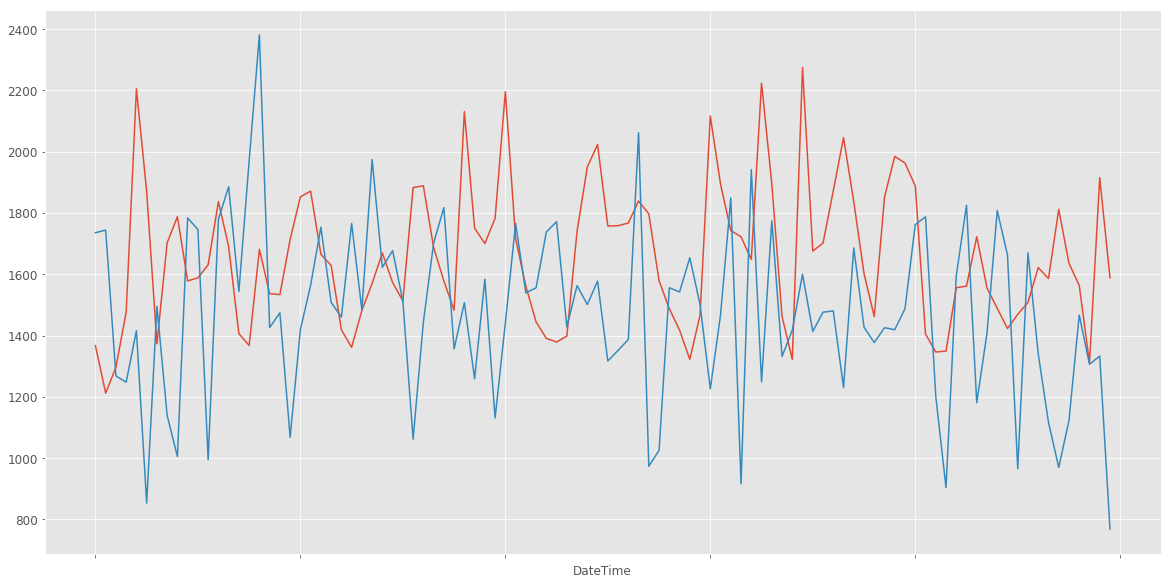

In [256]:
df3[:100].AQI.plot()
df3[:100].predictAQI.plot()
# df3[:100].predictAQI2.plot()

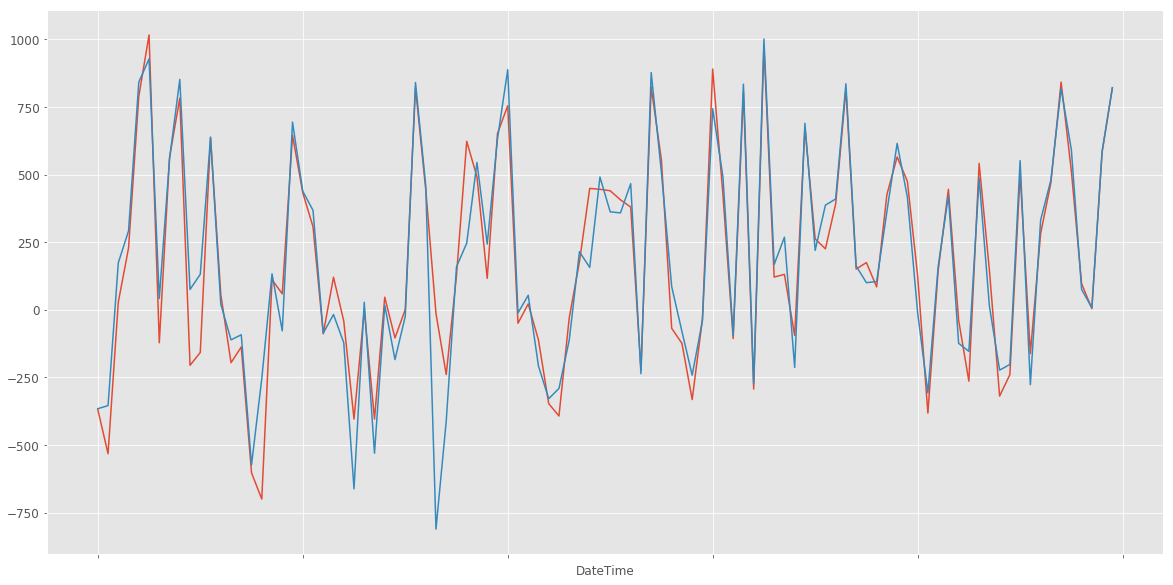

In [258]:
(df3[:100].AQI - df3[:100].predictAQI).plot()
(df3[:100].AQI - df3[:100].predictAQI2).plot()

In [259]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import expon, reciprocal

# # see https://docs.scipy.org/doc/scipy-0.19.0/reference/stats.html
# # for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# # Note: gamma is ignored when kernel is "linear"
# param_distribs = {
#         'max_depth': [2,3,4,5,6]
# #         'kernel': ['linear', 'rbf'],
# #         'C': reciprocal(20, 200000),
# #         'gamma': expon(scale=1.0),
#     }
# regressor_C = DecisionTreeRegressor(random_state=0)

# rnd_search = RandomizedSearchCV(regressor_C, param_distributions=param_distribs,
#                                 n_iter=5, cv=5, scoring='neg_mean_squared_error',
#                                 verbose=2, n_jobs=4, random_state=42)
# rnd_search.fit(X_train1, y_train1)


from sklearn.model_selection import GridSearchCV

param_grid = [
        {'max_depth': [2,3,4,5,6,10,20], 'random_state' : [0,1,2,3,4,5]}
]

regressor_D = DecisionTreeRegressor()
grid_search = GridSearchCV(regressor_D, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(X_train, y_train1)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] max_depth=2, random_state=0 .....................................
[CV] max_depth=2, random_state=0 .....................................
[CV] max_depth=2, random_state=0 .....................................
[CV] max_depth=2, random_state=0 .....................................
[CV] ...................... max_depth=2, random_state=0, total=   0.0s
[CV] ...................... max_depth=2, random_state=0, total=   0.0s
[CV] ...................... max_depth=2, random_state=0, total=   0.0s
[CV] ...................... max_depth=2, random_state=0, total=   0.0s
[CV] max_depth=2, random_state=1 .....................................
[CV] max_depth=2, random_state=1 .....................................
[CV] max_depth=2, random_state=0 .....................................
[CV] max_depth=2, random_state=1 .....................................
[CV] ...................... max_depth=2, random_state=1, total=   0.0s
[CV] ..........

[CV] ...................... max_depth=3, random_state=5, total=   0.0s
[CV] max_depth=3, random_state=5 .....................................
[CV] ...................... max_depth=4, random_state=0, total=   0.0s
[CV] ...................... max_depth=3, random_state=5, total=   0.0s
[CV] max_depth=4, random_state=1 .....................................
[CV] max_depth=4, random_state=0 .....................................
[CV] max_depth=4, random_state=0 .....................................
[CV] ...................... max_depth=4, random_state=0, total=   0.0s
[CV] ...................... max_depth=3, random_state=5, total=   0.0s
[CV] ...................... max_depth=4, random_state=1, total=   0.0s
[CV] ...................... max_depth=4, random_state=0, total=   0.0s
[CV] max_depth=4, random_state=0 .....................................
[CV] max_depth=3, random_state=5 .....................................
[CV] max_depth=4, random_state=1 .....................................
[CV] m

[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    1.2s


[CV] ...................... max_depth=5, random_state=5, total=   0.0s
[CV] ...................... max_depth=5, random_state=3, total=   0.0s
[CV] max_depth=5, random_state=5 .....................................
[CV] max_depth=5, random_state=4 .....................................
[CV] max_depth=6, random_state=0 .....................................
[CV] ...................... max_depth=5, random_state=4, total=   0.0s
[CV] ...................... max_depth=5, random_state=5, total=   0.0s
[CV] max_depth=5, random_state=5 .....................................
[CV] max_depth=5, random_state=4 .....................................
[CV] ...................... max_depth=5, random_state=4, total=   0.0s
[CV] ...................... max_depth=6, random_state=0, total=   0.0s
[CV] max_depth=5, random_state=4 .....................................
[CV] max_depth=6, random_state=0 .....................................
[CV] ...................... max_depth=5, random_state=4, total=   0.0s
[CV] m

[CV] max_depth=10, random_state=5 ....................................
[CV] max_depth=10, random_state=4 ....................................
[CV] ..................... max_depth=10, random_state=3, total=   0.0s
[CV] max_depth=10, random_state=4 ....................................
[CV] max_depth=20, random_state=0 ....................................
[CV] ..................... max_depth=10, random_state=4, total=   0.0s
[CV] max_depth=10, random_state=4 ....................................
[CV] ..................... max_depth=10, random_state=5, total=   0.1s
[CV] ..................... max_depth=10, random_state=4, total=   0.0s
[CV] max_depth=10, random_state=5 ....................................
[CV] max_depth=10, random_state=4 ....................................
[CV] ..................... max_depth=10, random_state=4, total=   0.0s
[CV] ..................... max_depth=20, random_state=0, total=   0.1s
[CV] max_depth=10, random_state=4 ....................................
[CV] .

[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    3.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'max_depth': [2, 3, 4, 5, 6, 10, 20], 'random_state': [0, 1, 2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [260]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

140.58915705824015

In [261]:
grid_search.best_params_

{'max_depth': 20, 'random_state': 0}